In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
from sklearn import datasets
from scipy.stats import ortho_group
import pandas as pd

In [2]:
import sys
sys.path.append('../code/')

In [3]:
from generate_data import make_data
from SWGG import SWGG_CP
from utils import random_slice

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


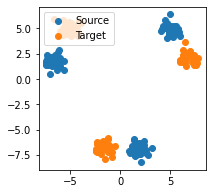

In [5]:
n=100
dim=2
X,Y=make_data('mog_reg',n,dim,device)
#X,Y=make_gaussians(n,dim=10)

pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
pl.legend(loc=2)

# Exact $W^2_2$

In [6]:
ns=X.shape[0]
nt=Y.shape[0]
a, b = torch.ones((ns,))/nt, torch.ones((nt,))/nt
#The exact Wasserstein distance
C=ot.dist(X,Y)#,metric='euclidean')
print('W = ',ot.emd2(a,b,C))

W =  tensor(12.6034)


# $PDW$ with random Monte-Carlo projections

In [7]:
n_proj=20
theta=random_slice(n_proj,dim).T
W,_,_=SWGG_CP(X,Y,theta)
print('PWD Monte Carlo = ',torch.mean(W))


PWD Monte Carlo =  tensor(48.5890)


# $PDW$ with Orthogonal projections

In [8]:
n_proj=3 #n_proj < dim
theta = ortho_group.rvs(dim)
theta = torch.tensor(theta[:,0:n_proj]).float()

W,_,_=SWGG_CP(X,Y,theta)
print('PWD Orthogonal = ',torch.mean(W))

PWD Orthogonal =  tensor(54.6067)


# PWD on non linear distributions

In [9]:
n_seed=10

n=200
dim=2

n_proj=200
distrib=['mog_reg','sub-manifold']

res=torch.empty((4,len(distrib),n_seed))

In [10]:
for j in range(n_seed):
    print(j,end=' ')
    for k,dis in enumerate(distrib):
        X,Y=make_data(dis,n,dim=10,device=device)
        ns=X.shape[0]
        nt=Y.shape[0]
        dim=X.shape[1]
        a, b = torch.ones((ns,))/ns, torch.ones((nt,))/nt
        
        #The exact Wasserstein distance
        C=ot.dist(X,Y)
        res[0,k,j]=ot.emd2(a,b,C,numItermax=1000000)
        
        #PWD Monte Carlo
        theta=random_slice(n_proj,dim).T
        res[1,k,j]=torch.mean(SWGG_CP(X,Y,theta)[0])
        
        #SWGG Monte Carlo
        res[3,k,j]=torch.min(SWGG_CP(X,Y,theta)[0])
        
        #PWD Orthogonal
        theta = ortho_group.rvs(dim)
        theta = torch.tensor(theta[:,0:min(n_proj,dim)]).float()
        res[2,k,j]=torch.mean(SWGG_CP(X,Y,theta)[0])  

0 1 2 3 4 5 6 7 8 9 

In [11]:
res_mean=torch.mean(res,axis=2)
res_std=torch.std(res,axis=2)
label=['Exact Wasserstein','PWD Monte Carlo','PWD Orthogonal','SWGG']

In [16]:
table=pd.DataFrame(torch.round(res_mean), columns=['Multi-modal','Low dimension manifold'],index=label)

table = table.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

In [17]:
table

,Multi-modal,Low dimension manifold
Exact Wasserstein,12.000000,12.000000
PWD Monte Carlo,54.000000,29.000000
PWD Orthogonal,54.000000,37.000000
SWGG,13.000000,13.000000
